In [137]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

In [138]:
df = pd.read_csv("data/musicgenre.csv")
df = df.dropna(subset=['music_genre'])

In [139]:
df

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,58878.0,BEXEY,GO GETTA,59.0,0.03340,0.913,-1.0,0.574,0.00000,C#,0.119,-7.022,Major,0.2980,98.02799999999999,4-Apr,0.330,Hip-Hop
50001,43557.0,Roy Woods,Drama (feat. Drake),72.0,0.15700,0.709,251860.0,0.362,0.00000,B,0.109,-9.814,Major,0.0550,122.04299999999999,4-Apr,0.113,Hip-Hop
50002,39767.0,Berner,Lovin' Me (feat. Smiggz),51.0,0.00597,0.693,189483.0,0.763,0.00000,D,0.143,-5.443,Major,0.1460,131.079,4-Apr,0.395,Hip-Hop
50003,57944.0,The-Dream,Shawty Is Da Shit,65.0,0.08310,0.782,262773.0,0.472,0.00000,G,0.106,-5.016,Minor,0.0441,75.88600000000001,4-Apr,0.354,Hip-Hop


# Augmentation du dataframe

### Valeurs manquantes

`df_droppped` : toutes les lignes contenant une valeur `None` sont drop
`df_mean` : toutes les valeurs `None` sont remplacées par la valeur moyenne de la colonne
`df_median` : toutes les valeurs `None` sont remplacées par la valeur médiane de la colonne

In [140]:
df_dropped = df.replace("?", None).dropna()
tempo = [float(i) for i in df.tempo if i != "?"]
df_mean = df.replace("?", np.mean(tempo))
df_median = df.replace("?", np.median(tempo))

In [141]:
print(np.mean([float(i) for i in df_dropped.tempo if i != "?"]))
print(np.mean([float(i) for i in df_mean.tempo if i != "?"]))
print(np.mean([float(i) for i in df_median.tempo if i != "?"]))

119.95296059529099
119.95296059529097
119.94559411999998


Pas beaucoup de différence entre les 3 méthodes. On va donc garder `df_dropped` dans un premier temps.

In [142]:
df_dropped["tempo"] = df_dropped["tempo"].astype(float)

In [143]:
print(f'Categorical Features: {len([x for x in df_dropped.columns if df_dropped[x].dtype == object])}')
print(f'Numerical Features: {len([x for x in df_dropped.columns if df_dropped[x].dtype == float])}')

Categorical Features: 6
Numerical Features: 12


### Durée

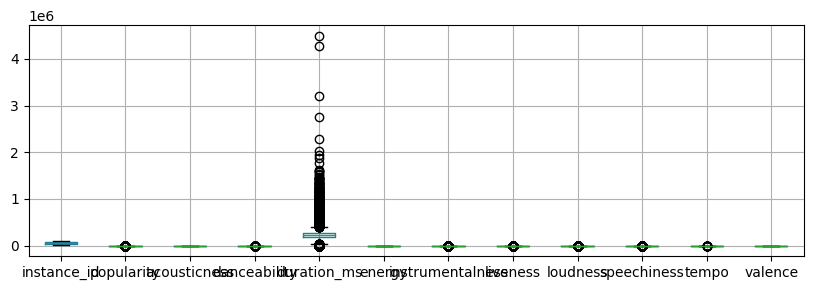

In [144]:
plt.figure(figsize=(10, 3))
df_dropped.select_dtypes(include=np.number).boxplot()
plt.show()

On observe des valeurs extrêmes pour la colonne `duration_ms`. On va donc la normaliser en la passant en secondes.

In [145]:
df_dropped["duration_ms"] = df_dropped["duration_ms"] / 1000

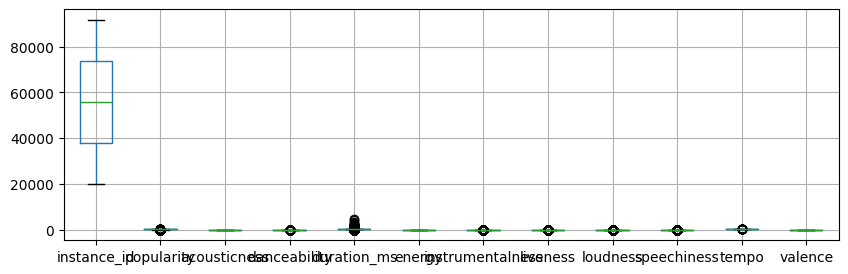

In [146]:
plt.figure(figsize=(10, 3))
df_dropped.select_dtypes(include=np.number).boxplot()
plt.show()

### Transformations des variables catégorielles en variables numériques

Afin de pouvoir utiliser les variables catégorielles dans notre modèle, on va les transformer en variables numériques.

In [147]:
from sklearn.preprocessing import LabelEncoder

In [148]:
encoder = LabelEncoder()
df_dropped['music_genre'] = encoder.fit_transform(df_dropped['music_genre'])

In [149]:
df_dropped['key'] = encoder.fit_transform(df_dropped['key'])
df_dropped['mode'] = encoder.fit_transform(df_dropped['mode'])

In [150]:
print(df_dropped['music_genre'].value_counts().sort_index())

music_genre
0    4495
1    4497
2    4470
3    4500
4    4486
5    4466
6    4520
7    4521
8    4504
9    4561
Name: count, dtype: int64


### Délétion des colonnes inutiles

In [151]:
print(f'Categorical Features: {[x for x in df_dropped.columns if df_dropped[x].dtype == object]}')

Categorical Features: ['artist_name', 'track_name', 'obtained_date']


In [152]:
df_dropped.drop(['track_name'],axis=1,inplace=True)

On suppose que le nom de la musique n'a pas d'impact sur le genre de musique.

In [153]:
df_dropped.drop(['instance_id'],axis=1,inplace=True)
df_dropped.drop(['obtained_date'],axis=1,inplace=True)

De la même manière, l'identifiant de la musique ainsi que la date d'obtention n'ont pas d'impact sur le genre de musique.

In [154]:
df_dropped.drop(['artist_name'],axis=1,inplace=True)
df_dropped.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,27.0,0.00468,0.652,-0.001,0.941,0.79200,1,0.115,-5.201,1,0.0748,100.889,0.759,5
1,31.0,0.01270,0.622,218.293,0.890,0.95000,5,0.124,-7.043,1,0.0300,115.002,0.531,5
2,28.0,0.00306,0.620,215.613,0.755,0.01180,11,0.534,-4.617,0,0.0345,127.994,0.333,5
3,34.0,0.02540,0.774,166.875,0.700,0.00253,4,0.157,-4.498,0,0.2390,128.014,0.270,5
4,32.0,0.00465,0.638,222.369,0.587,0.90900,9,0.157,-6.266,0,0.0413,145.036,0.323,5


On supprime également le nom de l'artiste.


### Corrélation

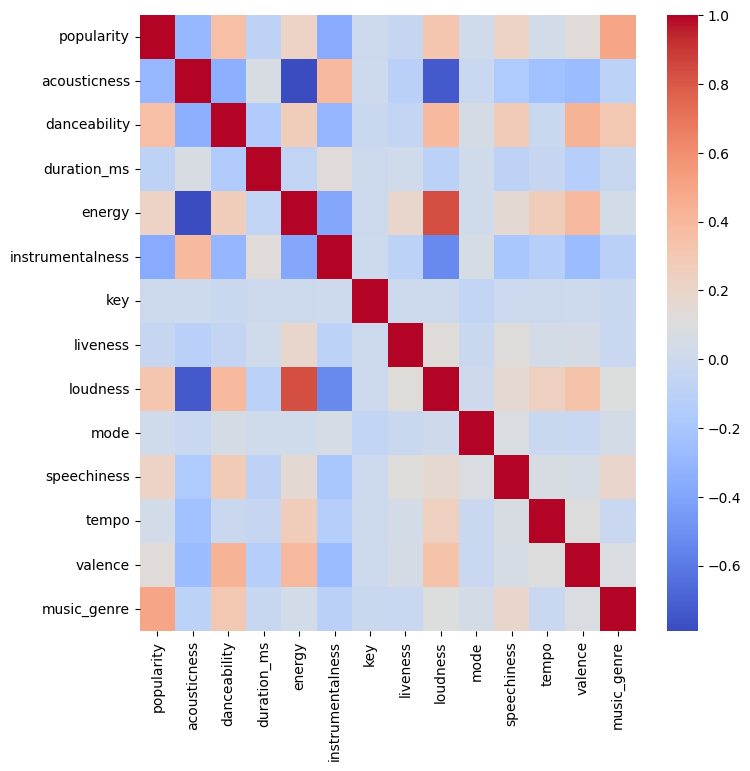

In [155]:
plt.figure(figsize=(8, 8))
sns.heatmap(df_dropped.select_dtypes(include=np.number).corr(), cmap='coolwarm')
plt.show()

On observe une forte corrélation entre `loudness` et `energy`. Cependant, on n'observe pas de corrélation entre `music_genre` et les autres variables pour le moment. Il va falloir creuser les transformations.

# Separation en train et test

In [156]:
from sklearn.model_selection import train_test_split

In [157]:
X = df_dropped.drop(columns=['music_genre'])
y = df_dropped['music_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.head()


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
47877,59.0,0.0317,0.778,227.573,0.7100,0.00000,2,0.0812,-7.175,0,0.1560,132.018,0.329
16417,57.0,0.0697,0.710,264.813,0.6980,0.00000,5,0.4780,-5.797,0,0.0332,104.007,0.852
36590,68.0,0.0214,0.638,196.600,0.6990,0.00000,0,0.0739,-6.736,0,0.0304,149.992,0.959
3381,49.0,0.2250,0.454,215.839,0.5650,0.00121,8,0.1120,-4.952,0,0.0314,74.501,0.224
42696,22.0,0.9910,0.270,180.320,0.0146,0.90000,0,0.0726,-34.135,1,0.0402,135.621,0.264


In [158]:
# Define and train the Random Forest classifier
rf_model = RandomForestClassifier(max_depth=15, min_samples_leaf=4, n_estimators=35)
rf_model.fit(X_train, y_train)
rf_y_hat = rf_model.predict(X_test)
print("accuracy:",accuracy_score(rf_y_hat, y_test))

accuracy: 0.5655264326965793


In [159]:
# Define and train the Logistic Regression classifier
lr_model = LogisticRegression(max_iter=000)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [160]:
# Define and train the KNN classifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

In [161]:
# Evaluate the models
rf_accuracy = accuracy_score(y_test, rf_y_hat)
lr_accuracy = accuracy_score(y_test, lr_predictions)
knn_accuracy = accuracy_score(y_test, knn_predictions)

In [162]:
rf_report = classification_report(y_test, rf_predictions)
lr_report = classification_report(y_test, lr_predictions)
knn_report = classification_report(y_test, knn_predictions)

# Print the evaluation results
print("Random Forest Classifier")
print(f"Accuracy: {rf_accuracy}")
print(rf_report)

print("Logistic Regression Classifier")
print(f"Accuracy: {lr_accuracy}")
print(lr_report)

print("K-Nearest Neighbors Classifier")
print(f"Accuracy: {knn_accuracy}")
print(knn_report)

Random Forest Classifier
Accuracy: 0.5655264326965793
              precision    recall  f1-score   support

           0       0.10      0.10      0.10       874
           1       0.12      0.12      0.12       927
           2       0.09      0.09      0.09       894
           3       0.10      0.10      0.10       914
           4       0.13      0.12      0.12       909
           5       0.11      0.11      0.11       920
           6       0.11      0.11      0.11       878
           7       0.09      0.09      0.09       877
           8       0.09      0.09      0.09       873
           9       0.09      0.09      0.09       938

    accuracy                           0.10      9004
   macro avg       0.10      0.10      0.10      9004
weighted avg       0.10      0.10      0.10      9004

Logistic Regression Classifier
Accuracy: 0.1009551310528654
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       874
           1      

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [166]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

# Assuming X_train and y_train are already defined and preprocessed
# Ensure y_train is one-hot encoded
y_train = to_categorical(y_train)

# Reshape X_train to fit the model input requirements (CNN expects 3D input)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Define the CNN model
model = Sequential()

# Add convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))

# Add additional convolutional layers
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Add the output layer
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(X_train_reshaped, y_train)
print(f'Training Accuracy: {train_accuracy}')



ModuleNotFoundError: No module named 'tensorflow'